In [1]:
from control import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# kp, ki, kd
# 0.9775171065493646, 0.9775171065493646, 999.0224828934506
# 4.887585532746823, 275.65982404692085, 984.3597262952102
# 7.820136852394917, 85.04398826979472, 936.4613880742913
# 31.28054740957967, 44.965786901270775, 956.989247311828
# 8.79765395894428, 75.26881720430107, 947.2140762463343
kp = 31.28054740957967
ki = 44.965786901270775
kd = 947.2140762463343

In [3]:
plant = tf([1], [64,9.6,0.48,0.008])
pid = tf([kd,kp,ki], [1,0])

In [7]:
sys = feedback(pid, plant, sign=1)

In [6]:
#sysd = sys.sample(Ts=0.025, method='zoh', alpha=None)

In [8]:
sys


6.062e+04 s^5 + 1.11e+04 s^4 + 3633 s^3 + 454.3 s^2 + 21.83 s + 0.3597
----------------------------------------------------------------------
            64 s^4 + 9.6 s^3 - 946.7 s^2 - 31.27 s - 44.97

In [10]:
time = np.arange(0,90)

In [14]:
sys1 = feedback(pid*plant, 1)
sys1d = sys1.sample(Ts=0.025, method='zoh', alpha=None)
sys1d


0.004617 z^3 - 0.004618 z^2 - 0.004608 z + 0.004609
---------------------------------------------------
    z^4 - 3.987 z^3 + 5.97 z^2 - 3.98 z + 0.9963

dt = 0.025

In [40]:
len(s[0])

3561

<function matplotlib.pyplot.show>

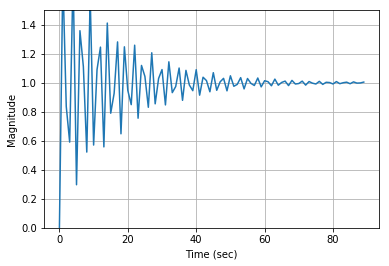

In [44]:
# PID compensated Step Response
t, s = step_response(sys1,T=time)
target = np.linspace(1, 1, num=len(t))
plt.figure()
#plt.plot(t,s,t,target)
plt.plot(t,s)
plt.ylim([0,1.5])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

In [45]:
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2*np.pi*t)

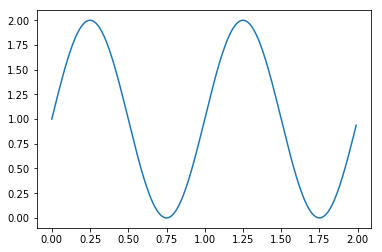

In [46]:
plt.plot(t, s)

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from control import *

In [ ]:
# Plant
num = [1]
den = [64,9.6,0.48,0.008]
G = tf(num, den)

# Plant Step Response
t, s = step_response(G)

#PID Controller
kp = 0.0361 
ki = 0.000731
kd = 0.6999

pid_num = [kd, kp, ki]
pid_den = [1, 0]
C = tf(pid_num,pid_den)

# System
T = feedback(C*G,1)

In [ ]:
# PID compensated Step Response
t, s = step_response(T)
target = np.linspace(1, 1, num=len(t))
plt.figure()
plt.plot(t,s,t,target)
#plt.plot(t,s)
plt.ylim([0,1.5])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

error = target - s

In [ ]:
import matplotlib
import numpy
from control import *
import math

In [ ]:
from deap import base, creator
# Crear clase FITNESS: ( Nombre de la clase, Delegando la clase como fitness, Posibles valores min y max del fitness )
creator.create("ControllerFitness", base.Fitness, weights=(1.0,))

# Crear clase CROMOSOMA: ( Nombre de la clase, type de los valores de la clase, Establecer fitness con la clase anterior )
creator.create("Controller", list, fitness=creator.ControllerFitness)

In [ ]:
import random
from deap import tools

IND_SIZE = 30 # ki bits + kp bits + kd bits

# Functions to initialize populations from individuals

toolbox = base.Toolbox()

# Crear el ATRIBUTO de cromosomas ( Nombre del registro para el toolbox, Función para crear un cromosoma aleatorio )
toolbox.register("bit_attribute", random.randint, 0, 1) # random.choice, '10')

# Crear el CROMOSOMA ( Nombre del registro, , La clase cromosoma, La clase atributo, Tamaño de la población )
# Cuando se llame a toolbox.individual(), este llamará a tool.initRepeat()
toolbox.register("controller", tools.initRepeat, creator.Controller, toolbox.bit_attribute, n=IND_SIZE)

# Crear la POBLACIÓN ( Nombre del registro, , Type del cromosoma, El cromosoma )
toolbox.register("population", tools.initRepeat, list, toolbox.controller)

In [ ]:
ind = toolbox.controller()

In [ ]:
def evaluate(controller):
    controller = ''.join(map(str,controller))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (math.pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (math.pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (math.pow(2,10) - 1) )
    
    # Plant
    num = [1]
    den = [64,9.6,0.48,0.008]
    plant = tf(num, den)
    
    pid_num = [kd, kp, ki]
    pid_den = [1, 0]
    pid = tf(pid_num,pid_den)

    # System
    sys = feedback(pid*plant,1)
    
    # PID compensated Step Response
    time = np.arange(0,900)
    t, s = step_response(sys,T=time)
    l = len(t)
    
    #total_error = sum(abs(1 - s))
    
    #total_error = sum(map(lambda x:abs(1-x)/l,s))
    
    total_error = 0
    while (1-s[l-total_error-1]) < 0.01:
        total_error = total_error + 1
    
    return (total_error),

In [ ]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [ ]:
ind = toolbox.controller()

In [ ]:
def main():
    pop = toolbox.population(n=40)
    # pop[0:100] = prev
    CXPB, MUTPB, NGEN = 0.7, 0.1, 40

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    minFit = (1,)
    #while minFit > (0.02,):
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        minFit = min(fitnesses)
        print("=START=================================================================")
        print(fitnesses)
        print("=END===================================================================")
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
    
    
    return pop

In [ ]:
w = [1,2,3,4]
w[len(w)-1]

In [ ]:
kx = main()

In [ ]:
for bits in kx:
    controller = ''.join(map(str,bits))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
    print([_kp,_ki,_kd,kp,ki,kd])

In [ ]:
evaluate(kx[1])

In [ ]:
controller = ''.join(map(str,kx[1]))
    
# PID controller
_kp = int(controller[0:10],2)
_ki = int(controller[10:20],2)
_kd = int(controller[20:30],2)

kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
print([_kp,_ki,_kd,kp,ki,kd])

In [47]:
import pandas as pd
import numpy as np

In [48]:
x = pd.read_excel('antihorario.xlsx') 
y = x['antihorapos']
x = x.drop('antihorapos', axis=1)

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)

In [50]:
from sklearn.linear_model import Lasso
model = Lasso()

In [51]:
model.fit(x_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [52]:
predicted = model.predict(x_test)

In [53]:
predicted.shape

(2000,)

In [59]:
model.score(x_test,y_test)

0.9964034840370886

([array([164., 188., 198., 174., 201., 189., 176., 182., 213., 315.]),
  array([170., 189., 199., 169., 201., 177., 165., 159., 196., 375.])],
 array([-511.14      , -455.67396116, -400.20792231, -344.74188347,
        -289.27584462, -233.80980578, -178.34376693, -122.87772809,
         -67.41168924,  -11.9456504 ,   43.52038844]),
 <a list of 2 Lists of Patches objects>)

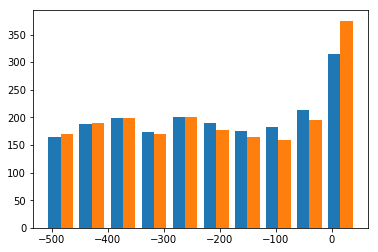

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([predicted, y_test])

In [58]:
y_test

442       1.18
2911   -256.10
2359   -190.17
377       1.26
1088    -21.85
4072   -396.55
522       0.56
4702   -474.87
4445   -440.47
3296   -303.77
1538    -82.96
3408   -315.71
4901   -498.81
3317   -305.80
4865   -494.83
2871   -252.44
1070    -20.41
4031   -392.84
3143   -283.71
1657   -100.09
1731   -111.09
724      -3.89
4932   -502.86
3785   -365.22
2695   -232.58
1618    -95.71
4500   -448.48
2519   -210.35
782      -5.89
1741   -111.09
         ...  
4146   -404.25
1217    -39.13
132       1.16
4743   -478.88
503       0.70
44        1.12
4129   -404.25
3560   -335.54
3040   -272.48
1961   -141.21
4153   -406.21
4441   -440.47
181       1.18
4934   -502.86
4229   -414.21
2884   -254.28
179       1.17
2367   -190.17
1393    -62.25
1904   -132.82
3718   -355.69
3986   -387.29
3387   -313.76
3066   -274.35
289       1.22
1071    -20.41
4370   -432.53
88        1.14
2623   -222.51
3223   -293.60
Name: antihorapos, Length: 2000, dtype: float64

In [ ]:
def pidController(kp, ki, kd, dt, n, pid1, error0, error1, error2):
    q1 = kp + 0.5*dt*ki + (kd/dt)
    q2 = dt*ki*0.5 - kp - (2*kd/dt)
    q3 = kd/dt
    #error0 = np.random.random()
    pid0 = pid1 + q1 * error0 + q2 * error1 + q3 * error2
    
    pid1 = pid0
    error1 = error0
    error2 = error1
    
    d = {'pwm': [pid0], 'time': [dt * n]}
    
    
    return [d, pid1, error1, error2]

In [ ]:
import matplotlib
import numpy
from control import *
import math
from deap import base, creator

In [ ]:
# Crear clase FITNESS: ( Nombre de la clase, Delegando la clase como fitness, Posibles valores min y max del fitness )
creator.create("ControllerFitness", base.Fitness, weights=(-1.0,))

# Crear clase CROMOSOMA: ( Nombre de la clase, type de los valores de la clase, Establecer fitness con la clase anterior )
creator.create("Controller", list, fitness=creator.ControllerFitness)

In [ ]:
import random
from deap import tools

IND_SIZE = 30 # ki bits + kp bits + kd bits

# Functions to initialize populations from individuals

toolbox = base.Toolbox()

# Crear el ATRIBUTO de cromosomas ( Nombre del registro para el toolbox, Función para crear un cromosoma aleatorio )
toolbox.register("bit_attribute", random.randint, 0, 1) # random.choice, '10')

# Crear el CROMOSOMA ( Nombre del registro, , La clase cromosoma, La clase atributo, Tamaño de la población )
# Cuando se llame a toolbox.individual(), este llamará a tool.initRepeat()
toolbox.register("controller", tools.initRepeat, creator.Controller, toolbox.bit_attribute, n=IND_SIZE)

# Crear la POBLACIÓN ( Nombre del registro, , Type del cromosoma, El cromosoma )
toolbox.register("population", tools.initRepeat, list, toolbox.controller)

In [ ]:
ind = toolbox.controller()

In [ ]:
def evaluatePID(kp, ki, kd):
    error = 0
    
    pid1 = 0
    error0 = 0
    error1 = 0
    error2 = 0

    for k in np.arange(20):
    #while error < 9000000
        d, pid1, error1, error2  = pidController(kp, ki, kd, 0.025, k, pid1, error0, error1, error2)
        y = model.predict(pd.DataFrame(data=d))
        error0 = 1 - y
        error = error + error0
        if (error > 1000000):
            error = 1000000
        #print([d, pid1, error1, error2 ])
        print(d)
    
    return error

In [ ]:
def evaluate(controller):
    controller = ''.join(map(str,controller))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (math.pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (math.pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (math.pow(2,10) - 1) )
    
    total_error = evaluatePID(kp, ki, kd)
    
    return (total_error),

In [ ]:
ind = toolbox.controller()

In [ ]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [ ]:
def main():
    pop = toolbox.population(n=40)
    # pop[0:100] = prev
    CXPB, MUTPB, NGEN = 0.7, 0.1, 40

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    minFit = (1,)
    #while minFit > (0.02,):
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        minFit = min(fitnesses)
        print("=START=================================================================")
        print(fitnesses)
        print("=END===================================================================")
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
    
    
    return pop

In [ ]:
q = main()

In [ ]:
for bits in q:
    controller = ''.join(map(str,bits))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
    print([_kp,_ki,_kd,kp,ki,kd])